# Expected Improvement

- https://krasserm.github.io/2018/03/21/bayesian-optimization/
- https://github.com/krasserm/bayesian-machine-learning/blob/dev/bayesian-optimization/bayesian_optimization_util.py
- https://towardsdatascience.com/conceptual-overview-of-bayesian-optimization-for-parameter-tuning-in-machine-learning-a3b1b4b9339f/
- https://medium.com/towards-data-science/bayesian-optimization-a-step-by-step-approach-a1cb678dd2ec

/Users/alextanhongpin/Library/Caches/pypoetry/virtualenvs/python-experimentation-for-engineers-8u4RfFJH-py3.12/lib/python3.12/site-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/alextanhongpin/Library/Caches/pypoetry/virtualenvs/python-experimentation-for-engineers-8u4RfFJH-py3.12/lib/python3.12/site-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/alextanhongpin/Library/Caches/pypoetry/virtualenvs/python-experimentation-for-engineers-8u4RfFJH-py3.12/lib/python3.12/site-packages/

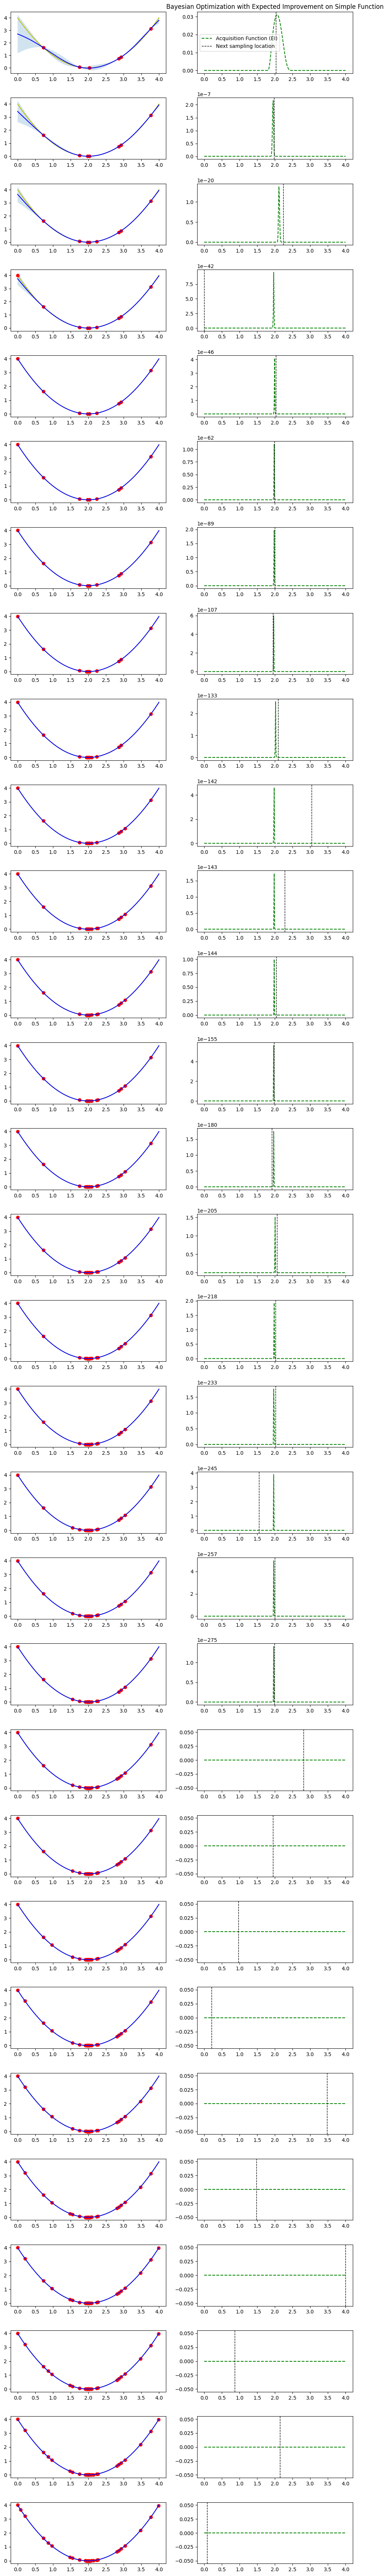

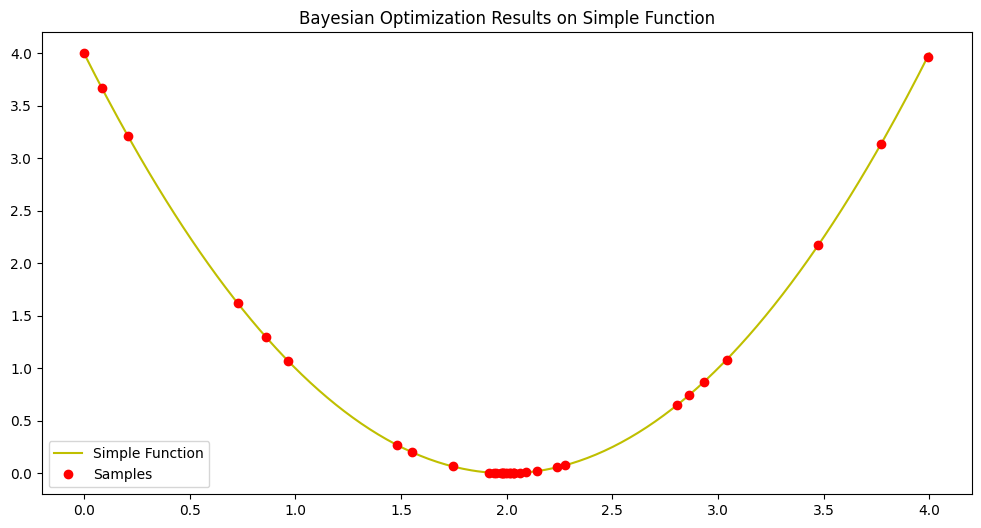

Best value found: y = 2.228676999901858e-06 at x = 2.001492875413389


In [1]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern


# Define a simple test function to be minimized
def simple_function(x):
    return (x - 2) ** 2


# Define the acquisition function (Expected Improvement)
def expected_improvement(X, X_sample, Y_sample, gpr, xi=0.01):
    """EI that find the minimum"""
    mu, sigma = gpr.predict(X, return_std=True)
    mu_sample = gpr.predict(X_sample)
    mu_sample_opt = np.min(mu_sample)

    with np.errstate(divide="warn"):
        imp = mu_sample_opt - mu - xi
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0

    return ei


# Propose the next sampling point by optimizing the acquisition function
def propose_location(acquisition, X_sample, Y_sample, gpr, bounds, n_restarts=25):
    dim = bounds.shape[0]
    min_val = 1
    min_x = None

    def min_obj(X):
        return -acquisition(X.reshape(-1, dim), X_sample, Y_sample, gpr)

    for x0 in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, dim)):
        res = minimize(min_obj, x0=x0, bounds=bounds, method="L-BFGS-B")
        if res.fun < min_val:
            min_val = res.fun
            min_x = res.x

    return min_x.reshape(-1, 1)


# Bayesian Optimization loop
def bayesian_optimization(n_iters, sample_loss, bounds, n_pre_samples=5):
    X_sample = np.random.uniform(
        bounds[:, 0], bounds[:, 1], size=(n_pre_samples, bounds.shape[0])
    )
    Y_sample = sample_loss(X_sample)

    kernel = ConstantKernel(1.0) * Matern(nu=2.5)
    gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-6)

    plt.figure(figsize=(12, n_iters * 3))
    plt.subplots_adjust(hspace=0.4)

    for i in range(n_iters):
        gpr.fit(X_sample, Y_sample)

        X_next = propose_location(expected_improvement, X_sample, Y_sample, gpr, bounds)
        Y_next = sample_loss(X_next)

        X_sample = np.vstack((X_sample, X_next))
        Y_sample = np.vstack((Y_sample, Y_next))

        # Plot the acquisition function
        plot_acquisition_function(
            X_sample, Y_sample, X_next, gpr, bounds, n_iters=n_iters, i=i
        )

    return X_sample, Y_sample


# Plot the acquisition function
def plot_acquisition_function(
    X_sample, Y_sample, X_next, gpr, bounds, xi=0.01, n_iters=None, i=None
):
    X = np.linspace(*bounds[0], 300).reshape(-1, 1)
    Y = simple_function(X)
    mu, sigma = gpr.predict(X, return_std=True)
    acquisition = expected_improvement(X, X_sample, Y_sample, gpr, xi)

    plt.subplot(n_iters, 2, 2 * i + 1)
    plt.plot(X, Y, "y-", label="Simple Function")
    plt.plot(X_sample, Y_sample, "ro", label="Samples")
    plt.plot(X, mu, "b-", label="GP Mean")
    plt.fill_between(
        X.ravel(), mu - 1.96 * sigma, mu + 1.96 * sigma, alpha=0.2, label="GP 95% CI"
    )

    plt.subplot(n_iters, 2, 2 * i + 2)
    plt.plot(X, acquisition, "g--", label="Acquisition Function (EI)")
    plt.axvline(x=X_next, ls="--", c="k", lw=1, label="Next sampling location")

    if i == 0:
        plt.legend()
        plt.title("Bayesian Optimization with Expected Improvement on Simple Function")


# Plot the results
def plot_results(X_sample, Y_sample, bounds):
    X = np.linspace(*bounds[0], 300).reshape(-1, 1)
    Y = simple_function(X)

    plt.figure(figsize=(12, 6))
    plt.plot(X, Y, "y-", label="Simple Function")
    plt.plot(X_sample, Y_sample, "ro", label="Samples")
    plt.legend()
    plt.title("Bayesian Optimization Results on Simple Function")
    plt.show()


# Define the bounds of the search space
bounds = np.array([[0.0, 4.0]])

# Run Bayesian Optimization
X_sample, Y_sample = bayesian_optimization(
    n_iters=30, sample_loss=simple_function, bounds=bounds
)

# Plot the final results
plot_results(X_sample, Y_sample, bounds)

# Print the best value found
best_index = np.argmin(Y_sample)
print(
    f"Best value found: y = {Y_sample[best_index][0]} at x = {X_sample[best_index][0]}"
)

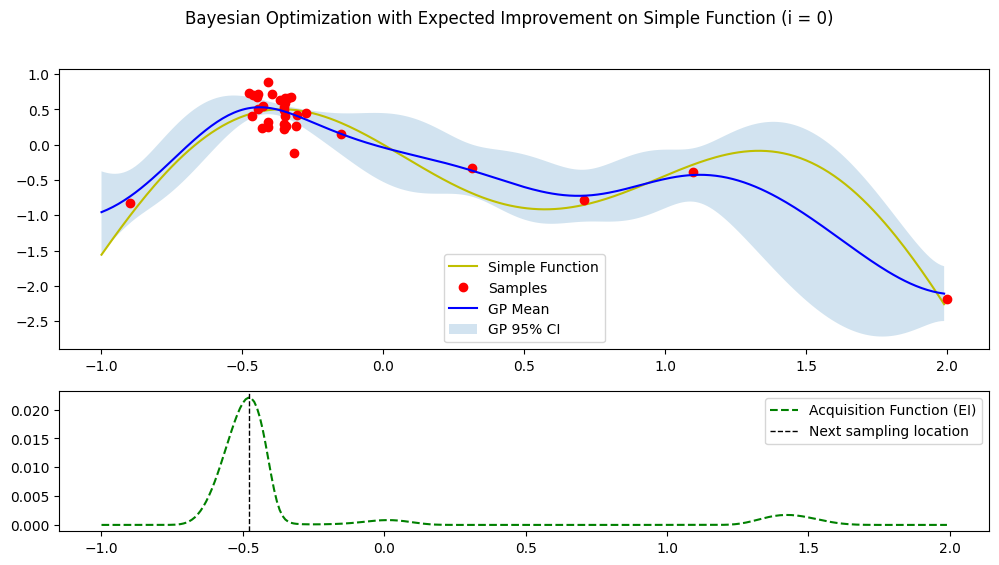

In [2]:
# Plot the acquisition function
def expected_improvement(X, X_sample, Y_sample, gpr, xi=0.01):
    """
    Computes the EI at points X based on existing samples X_sample
    and Y_sample using a Gaussian process surrogate model.

    Args:
        X: Points at which EI shall be computed (m x d).
        X_sample: Sample locations (n x d).
        Y_sample: Sample values (n x 1).
        gpr: A GaussianProcessRegressor fitted to samples.
        xi: Exploitation-exploration trade-off parameter.

    Returns:
        Expected improvements at points X.
    """
    mu, sigma = gpr.predict(X, return_std=True)
    mu_sample = gpr.predict(X_sample)
    # Needed for noise-based model,
    # otherwise use np.max(Y_sample).
    # See also section 2.4 in [1]
    mu_sample_opt = np.max(mu_sample)

    with np.errstate(divide="warn"):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma <= 0.0] = 0.0

    return ei


bounds = np.array([[-1.0, 2.0]])
noise = 0.2


def f(X, noise=noise):
    return -np.sin(3 * X) - X**2 + 0.7 * X + noise * np.random.randn(*X.shape)


def record_acquisition_function(
    X_sample, Y_sample, X_next, gpr, bounds, xi=0.01, axs=None, sample_loss=None
):
    X = np.arange(*bounds[0], 0.01).reshape(-1, 1)
    Y = sample_loss(X, 0)
    mu, sigma = gpr.predict(X, return_std=True)
    acquisition = expected_improvement(X, X_sample, Y_sample, gpr, xi)

    axs[0].plot(X, Y, "y-", label="Simple Function")
    axs[0].plot(X_sample, Y_sample, "ro", label="Samples")
    axs[0].plot(X, mu, "b-", label="GP Mean")
    axs[0].fill_between(
        X.ravel(), mu - 1.96 * sigma, mu + 1.96 * sigma, alpha=0.2, label="GP 95% CI"
    )
    axs[0].legend()

    axs[1].plot(X, acquisition, "g--", label="Acquisition Function (EI)")
    axs[1].axvline(x=X_next, ls="--", c="k", lw=1, label="Next sampling location")
    axs[1].legend()


# Bayesian Optimization loop
def simulate_bayesian_optimization(n_iters, sample_loss, bounds, n_pre_samples=5):
    global X_sample
    global Y_sample
    X_sample = np.array([[-0.9], [1.1]])
    Y_sample = sample_loss(X_sample)

    kernel = ConstantKernel(1.0) * Matern(nu=2.5)
    gpr = GaussianProcessRegressor(kernel=kernel, alpha=noise**2)

    fig, axs = plt.subplots(
        2, 1, figsize=(12, 6), gridspec_kw={"height_ratios": [2, 1]}
    )

    def update(frame):
        fig.suptitle(
            f"Bayesian Optimization with Expected Improvement on Simple Function (i = {frame})"
        )
        global X_sample
        global Y_sample
        # Clear axis
        [ax.cla() for ax in axs]
        gpr.fit(X_sample, Y_sample)

        X_next = propose_location(expected_improvement, X_sample, Y_sample, gpr, bounds)
        Y_next = sample_loss(X_next)

        X_sample = np.vstack((X_sample, X_next))
        Y_sample = np.vstack((Y_sample, Y_next))

        # Plot the acquisition function
        record_acquisition_function(
            X_sample, Y_sample, X_next, gpr, bounds, axs=axs, sample_loss=sample_loss
        )
        return (fig,)

    return animation.FuncAnimation(fig=fig, func=update, frames=n_iters, interval=300)


ani = simulate_bayesian_optimization(n_iters=30, sample_loss=f, bounds=bounds)
ani.save(filename="./bo_ei.gif")